In [4]:
import re
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score


if torch.cuda.is_available():
    from torch.cuda import FloatTensor, LongTensor
else:
    from torch import FloatTensor, LongTensor
    
np.random.seed(42)

# Convolutional neural networks

## Surname classification

We will learn to predict whether a word is a surname.

In [24]:
df = pd.read_csv('.data/surnames.csv')
df.head()

,surname,nationality
0,Woodford,English
1,Coté,French
2,Kore,English
3,Koury,Arabic
4,Lebzak,Russian


In [25]:
train_data, test_data, train_labels, test_labels = train_test_split(df['surname'], df['nationality'], test_size=0.33, random_state=42)

In [26]:
list(zip(train_data, train_labels))[::1500]

[('Ponidelko', 'Russian'),
 ('Wruck', 'German'),
 ('Ahmad', 'English'),
 ('Wakelin', 'English'),
 ('Oneil', 'English')]

The data is also very balanced

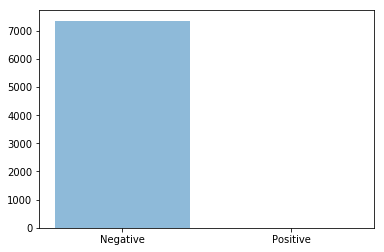

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline

positive_count = np.sum(train_labels == 1)
negative_count = len(train_labels) - positive_count
 
plt.bar(np.arange(2), [negative_count, positive_count], align='center', alpha=0.5)
plt.xticks(np.arange(2), ('Negative', 'Positive'))
    
plt.show()

In [28]:
print('Accuracy = {:.2%}'.format((train_labels == 0).mean()))

Accuracy = 0.00%


However, it will be rather useless to always say that the word is not a surname. This, of course, is a question - what is worse, in vain to declare a word a last name (a mistake of the first kind) or not to find a last name.

<img src="https://effectsizefaq.files.wordpress.com/2010/05/type-i-and-type-ii-errors.jpg" style="border:none;width:35%">

We will measure precision, recall and their combination - $ F_1 $ -measure.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Precisionrecall.svg/350px-Precisionrecall.svg.png" style="border:none;width:25%">

$$\text{precision} = \frac{tp}{tp + fp}.$$
$$\text{recall} = \frac{tp}{tp + fn}.$$
$$\text{F}_1 = 2 \cdot \frac{\text{precision} \cdot \text{recall}}{\text{precision} + \text{recall}}.$$

Let's start with a baseline on the regulars.

And now seriously - a baseline on logistic regression over N-gram characters.

**Assignment** Make a classification with the LogisticRegression model. Calculate the F1-measure.

In [43]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

vectorizer = CountVectorizer(analyzer='char', ngram_range=(1, 3), lowercase=False)
classifier = RandomForestClassifier(n_estimators=10, max_depth=None, min_samples_split=2, random_state=0)

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(df['surname'], df['nationality'])

Pipeline(memory=None,
     steps=[('vectorizer', CountVectorizer(analyzer='char', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=False, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 3), preprocessor=None, stop_words=None,
      ...imators=10, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False))])

In [45]:
# test_preds = model.predict(df['surname'])
# print('F1-score = {:.2%}'.format(f1_score(df['nationality'], test_preds)))

from sklearn.metrics import accuracy_score
preds = model.predict(test_data)
print('Test accuracy = {:.2%}'.format(accuracy_score(test_labels, preds)))

Test accuracy = 96.08%


Look at the predictions

In [46]:
import eli5

eli5.show_weights(model, vec=vectorizer, top=40)

Weight,Feature
0.0134 ± 0.0057,a
0.0119 ± 0.0083,e
0.0111 ± 0.0155,v
0.0107 ± 0.0212,ov
0.0102 ± 0.0039,i
0.0102 ± 0.0137,ev
0.0096 ± 0.0054,n
0.0085 ± 0.0032,o
0.0082 ± 0.0071,h
0.0078 ± 0.0026,s


In [49]:
# eli5.show_prediction(model, df[10], vec=vectorizer, targets=['surname'], target_names=['word', 'surname'])

In addition to the blunt counting of the F1-score, you can look at precision-recall curves. First, they are beautiful. Secondly, it is clear from them that you can improve the quality (F1-score) by selecting another threshold - ** although it is impossible to do this on the test **.

In [53]:
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

precision_score(test_labels, preds, average='macro')

0.9187054759579859

In [54]:
f1_score(test_labels, preds, average='macro')

0.8978852714706169

In [55]:
# from sklearn.metrics import precision_recall_curve

# precision, recall, _ = precision_recall_curve(df['surname'], model.predict_proba(df['nationality'])[:, 1])

# plt.figure(figsize=(7, 7))
# f_scores = np.linspace(0.2, 0.8, num=4)
# lines = []
# labels = []
# for f_score in f_scores:
#     x = np.linspace(0.01, 1)
#     y = f_score * x / (2 * x - f_score)
#     l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
#     plt.annotate('F1 = {0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

# plt.plot(recall, precision)

# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('Recall')
# plt.ylabel('Precision')
# plt.title('Precision-Recall Curve')

# plt.show()

**Task** Come up with signs to improve the quality of the model.

## Character-Level Convolutions

### General description of convolutions

Let me remind you that convolutions are what started the HYIP of neural networks in the area of ​​the 2012th.

They work like this:
<img src="https://image.ibb.co/e6t8ZK/Convolution.gif" width="50%">

From [Feature extraction using convolution](http://deeplearning.stanford.edu/wiki/index.php/Feature_extraction_using_convolution).

Formally - filter sets are learned, each of which is scalar multiplied by elements of the matrix of attributes. In the picture above, the original matrix collapses with the filter.
$$
 \begin{pmatrix}
  1 & 0 & 1 \\
  0 & 1 & 0 \\
  1 & 0 & 1
 \end{pmatrix}
$$

But we must not forget that convolutions usually have another dimension, such as the number of channels. For example, pictures usually have three channels: RGB.
It clearly demonstrates how filters look like [here] (http://cs231n.github.io/convolutional-networks/#conv).

After convolutions, pooling layers usually follow. They help reduce the dimension of the tensor with which to work. The most common is max-pooling:

<img src="http://cs231n.github.io/assets/cnn/maxpool.jpeg" width="50%">

### Text wrappers

For convolution texts, they work as n-gram detectors (approximately). A canonical example of a symbolic convolution network:

<img src="https://image.ibb.co/bC3Xun/2018_03_27_01_24_39.png" width="50%">

From [Character-Aware Neural Language Models](https://arxiv.org/abs/1508.06615)

* How many filters does the example use? *

The picture shows how 2, 3, and 4 grams are extracted from a word. For example, yellow is trigrams. A yellow filter is applied to all trigrams in a word, and then the strongest signal is extracted using global max-pooling.

What does this mean, if specifically?

Each character is displayed using embeddings in some vector. And their sequences are in the concatenation of embeddings.

For example, "abs" $ \ to [v_a; v_b; v_s] \in \mathbb {R} ^ {3 d} $, where $ d $ is the embedding dimension. The yellow filter $ f_k $ has the same dimension $ 3d $.

Its attachment is the scalar product $ \left ([v_a; v_b; v_s] \odot f_k \right) \in \mathbb R $ (one of the yellow squares in the feature map for this filter).

Max-pooling selects $ max_i \left ([v_ {i-1}; v_ {i}; v_ {i + 1}] \odot f_k \right) $, where $ i $ runs over all indexes of the word from 1 to $ | w | - $ 1 (or over a larger range, if there are paddings).
This maximum corresponds to the trigram that is closest to the filter over the cosine distance.

As a result, after max-pooling, the vector encodes information about which of the n-grams met in the word: if a trigram close to our $ f_k $ met, then the vector will have a great value in the $ k $ position of the vector, otherwise small

And we just learn the filters. That is, the network must learn to determine which of the n-grams are significant and which are not.

### Toy example

Let's look at an example of what is happening there. Take the word:

In [1]:
word = 'Hello Word'

In [2]:
char2index = {symb: ind for ind, symb in enumerate(set(word))}

char2index

{'H': 0, 'o': 1, 'l': 2, 'e': 3, 'd': 4, 'r': 5, 'W': 6, ' ': 7}

Each character is associated with embedding. The easiest way to do embeddingings is to take a single matrix. When we had tens of thousands of words, such embeddings were not very good, but now only a few characters are quite adequate to assign them orthogonal vectors of small dimension.

In [5]:
embeddings = torch.eye(len(char2index))

embeddings

tensor([[1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1.]])

Construct the tensor of the indexes of the characters of the word:

In [17]:
word_tensor = torch.LongTensor([char2index[symb] for symb in word])

word_tensor

tensor([0, 3, 2, 2, 1, 7, 6, 1, 5, 4])

Let's display it in embeddings. Got the same rectangle as in the picture (transposition is necessary to look in the same direction).

In [18]:
word_embs = embeddings[word_tensor].t()

word_embs

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 1., 0., 0.],
        [0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]])

In [19]:
word_embs.size()

torch.Size([8, 10])

Now it came to convolutions. Let's make the filter-detector of the trigram `new`:

In [20]:
kernel_name = 'Hel'

kernel_indices = torch.LongTensor([char2index[symb] for symb in kernel_name])
kernel_weights = embeddings[kernel_indices].t()

kernel_weights

tensor([[1., 0., 0.],
        [0., 0., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]])

To calculate the convolution, use the function:
```python
F.conv2d(input, weight, bias=None, stride=1, padding=0, dilation=1, groups=1) -> Tensor
```

input: input tensor of shape ($N \times C_{in} \times H_{in} \times W_{in}$)  
weight: filters of shape ($C_{out} \times C_{in} \times H_{out} \times W_{out}$)

$ N $ - the size of the batch (1 for us). $ C_ {in} $ - the number of channels. In our case, it will always be 1 (for now). $ C_ {out} $ - the number of filters. It is still 1.

We will need four-dimensional tensors, for this we use `view`:

In [21]:
word_embs = word_embs.view(1, 1, word_embs.shape[0], word_embs.shape[1])
word_embs.size()

torch.Size([1, 1, 8, 10])

In [22]:
kernel_weights = kernel_weights.view(1, 1, kernel_weights.shape[0], kernel_weights.shape[1])

conv_result = F.conv2d(word_embs, kernel_weights)[0, 0]

print('Conv =', conv_result)
print('Max pooling =', conv_result.max())

Conv = tensor([[[[3., 1., 0., 0., 0., 0., 0., 0.]]]])
Max pooling = tensor(3.)


Convolution said that this filter is in the last position. Puling said, do not care what position - the main thing, he is.

### Data preparation

The first step is to determine how long our words are. We confine ourselves to some number, and the longer ones will be cut off.

In [56]:
from collections import Counter 
    
def find_max_len(counter, threshold):
    sum_count = sum(counter.values())
    cum_count = 0
    for i in range(max(counter)):
        cum_count += counter[i]
        if cum_count > sum_count * threshold:
            return i
    return max(counter)

word_len_counter = Counter()
for word in train_data:
    word_len_counter[len(word)] += 1
    
threshold = 0.99
MAX_WORD_LEN = find_max_len(word_len_counter, threshold)

print('Max word length for {:.0%} of words is {}'.format(threshold, MAX_WORD_LEN))

Max word length for 99% of words is 12


Let's collect a mapping from characters to indexes.

In [57]:
chars = set()
for word in train_data:
    chars.update(word)

char_index = {c : i + 1 for i, c in enumerate(chars)}
char_index['<pad>'] = 0
    
print(char_index)

{'R': 1, 'ü': 2, 'q': 3, 'ú': 4, 'V': 5, 'M': 6, 'ã': 7, 'C': 8, 'Ż': 9, 'Á': 10, 'h': 11, ':': 12, 'F': 13, 'N': 14, 'S': 15, 'ö': 16, 'ç': 17, 'I': 18, 'ì': 19, 'A': 20, 'è': 21, 'u': 22, 'ñ': 23, '/': 24, 'k': 25, 'f': 26, 'v': 27, 't': 28, 'E': 29, 'Z': 30, 'ń': 31, 'X': 32, 'y': 33, 'g': 34, 'c': 35, 'm': 36, 'W': 37, 'e': 38, 'ò': 39, 'L': 40, 'O': 41, 'ê': 42, 'z': 43, 'à': 44, 'Q': 45, 'É': 46, 'b': 47, 'j': 48, 'K': 49, 'D': 50, 'ó': 51, 'õ': 52, '1': 53, 'P': 54, 'é': 55, 'B': 56, 'w': 57, 'ä': 58, 'o': 59, 'H': 60, 'r': 61, 'á': 62, 'Ś': 63, "'": 64, 'i': 65, 'n': 66, 'G': 67, 's': 68, 'T': 69, '-': 70, 'Y': 71, 'x': 72, 'l': 73, 'd': 74, 'U': 75, 'a': 76, 'J': 77, 'í': 78, 'ß': 79, 'p': 80, '<pad>': 0}


**Task** Convert data

In [0]:
def convert_data(data, max_word_len, char_index):
    return <np array>

X_train = convert_data(train_data, MAX_WORD_LEN, char_index)
X_test = convert_data(test_data, MAX_WORD_LEN, char_index)

In [0]:
def iterate_batches(X, y, batch_size):
    num_samples = X.shape[0]

    indices = np.arange(num_samples)
    np.random.shuffle(indices)
    
    for start in range(0, num_samples, batch_size):
        end = min(start + batch_size, num_samples)
        
        batch_idx = indices[start: end]
        
        yield X[batch_idx], y[batch_idx]

### ConvCharNN

Now we build a convolutional model.

Let it build trigrams - that is, apply filters for 3 characters.

Let's start with the sequence: `nn.Embedding -> nn.Conv2d -> nn.ReLU -> max pooling -> nn.Linear`

`nn.Conv2d` is the layer containing the creation and initialization of filters, and calling` F.conv2d` to them and the input.

* Life hacking: sequences of operations can be packed in `nn.Sequential`.

In [0]:
class ConvClassifier(nn.Module):
    def __init__(self, vocab_size, emb_dim, filters_count):
        super().__init__()
        
        self._embedding = ...
        self._dropout = nn.Dropout(0.2)
        self._conv3 = ...
        self._out_layer = ...
        
    def forward(self, inputs):
        '''
        inputs - LongTensor with shape (batch_size, max_word_len)
        outputs - FloatTensor with shape (batch_size,)
        '''
        
        outputs = self.embed(inputs)
        return self._out_layer(outputs).squeeze(-1)
    
    def embed(self, inputs):
        <calc word embedding>

Проверьте, что всё работает:

In [0]:
X_batch, y_batch = next(iterate_batches(X_train, train_labels, 32))
X_batch, y_batch = torch.LongTensor(X_batch), torch.LongTensor(y_batch)

model = ConvClassifier(len(char_index) + 1, 24, 64)
logits = model(X_batch)

**Задание** Подсчитайте precision, recall и F1-score для полученных предсказаний.

In [0]:
<calc precision, recall, f1-score>

**Задание** Напишем теперь цикл обучения, который не слишком сложно будет переиспользовать

In [0]:
import math
import time

def do_epoch(model, criterion, data, batch_size, optimizer=None):
    epoch_loss, epoch_tp, epoch_fp, epoch_fn = 0, 0, 0, 0
    
    is_train = not optimizer is None
    model.train(is_train)
    
    data, labels = data
    batchs_count = math.ceil(data.shape[0] / batch_size)
    
    with torch.autograd.set_grad_enabled(is_train):
        for i, (X_batch, y_batch) in enumerate(iterate_batches(data, labels, batch_size)):
            X_batch, y_batch = LongTensor(X_batch), FloatTensor(y_batch)

            logits = <calc logits>

            loss = <calc loss>
            epoch_loss += loss.item()

            if is_train:
                <how to optimize the beast?>

            <u can move the stuff to some function>
            tp = <calc true positives>
            fp = <calc false positives>
            fn = <calc false negatives>

            precision = ...
            recall = ...
            f1 = ...
            
            epoch_tp += tp
            epoch_fp += fp
            epoch_fn += fn

            print('\r[{} / {}]: Loss = {:.4f}, Precision = {:.2%}, Recall = {:.2%}, F1 = {:.2%}'.format(
                  i, batchs_count, loss.item(), precision, recall, f1), end='')
        
    precision = ...
    recall = ...
    f1 = ...
        
    return epoch_loss / batchs_count, recall, precision, f1

def fit(model, criterion, optimizer, train_data, epochs_count=1, 
        batch_size=32, val_data=None, val_batch_size=None):
    if not val_data is None and val_batch_size is None:
        val_batch_size = batch_size
        
    for epoch in range(epochs_count):
        start_time = time.time()
        train_loss, train_recall, train_precision, train_f1 = do_epoch(
            model, criterion, train_data, batch_size, optimizer
        )
        
        output_info = '\rEpoch {} / {}, Epoch Time = {:.2f}s: Train Loss = {:.4f}, Precision = {:.2%}, Recall = {:.2%}, F1 = {:.2%}'
        if not val_data is None:
            val_loss, val_recall, val_precision, val_f1 = do_epoch(model, criterion, val_data, val_batch_size, None)
            
            epoch_time = time.time() - start_time
            output_info += ', Val Loss = {:.4f}, Precision = {:.2%}, Recall = {:.2%}, F1 = {:.2%}'
            print(output_info.format(epoch+1, epochs_count, epoch_time, 
                                     train_loss, train_recall, train_precision, train_f1,
                                     val_loss, val_recall, val_precision, val_f1))
        else:
            epoch_time = time.time() - start_time
            print(output_info.format(epoch+1, epochs_count, epoch_time, train_loss))

In [0]:
model = ConvClassifier(len(char_index) + 1, 24, 128).cuda()

criterion = nn.BCEWithLogitsLoss().cuda()

optimizer = optim.Adam([param for param in model.parameters() if param.requires_grad])

fit(model, criterion, optimizer, train_data=(X_train, train_labels), epochs_count=200, 
    batch_size=512, val_data=(X_test, test_labels), val_batch_size=1024)

**Task** Check the classifier on your last name.

It is necessary not to forget to transfer the model to the inference mode - some layers on the train and inference behave differently.

In [0]:
model.eval()

surname = "..."
surname_tensor = ...
print('P({} is surname) = {}'.format(surname, torch.sigmoid(model(surname_tensor))))

**Задание** Постройте precision-recall curve для данного классификатора и предыдущей модели

### Embeddingd visualization

**Assignment** Visualize word embeddings, as was done before

In [0]:
import bokeh.models as bm, bokeh.plotting as pl
from bokeh.io import output_notebook

from sklearn.manifold import TSNE
from sklearn.preprocessing import scale


def draw_vectors(x, y, radius=10, alpha=0.25, color='blue',
                 width=600, height=400, show=True, **kwargs):
    """ draws an interactive plot for data points with auxilirary info on hover """
    output_notebook()
    
    if isinstance(color, str): 
        color = [color] * len(x)
    data_source = bm.ColumnDataSource({ 'x' : x, 'y' : y, 'color': color, **kwargs })

    fig = pl.figure(active_scroll='wheel_zoom', width=width, height=height)
    fig.scatter('x', 'y', size=radius, color='color', alpha=alpha, source=data_source)

    fig.add_tools(bm.HoverTool(tooltips=[(key, "@" + key) for key in kwargs.keys()]))
    if show: 
        pl.show(fig)
    return fig


def get_tsne_projection(word_vectors):
    tsne = TSNE(n_components=2, verbose=100)
    return scale(tsne.fit_transform(word_vectors))
    
    
def visualize_embeddings(embeddings, token, colors):
    tsne = get_tsne_projection(embeddings)
    draw_vectors(tsne[:, 0], tsne[:, 1], color=colors, token=token)

In [0]:
word_indices = np.random.choice(np.arange(len(test_data)), 1000, replace=False)
words = [test_data[ind] for ind in word_indices]
labels = test_labels[word_indices]

word_tensor = convert_data(words, max(len(x) for x in words), char_index)
embeddings = <calc embeddings>

colors = ['red' if label else 'blue' for label in labels]

visualize_embeddings(embeddings, words, colors)

### Visualization of the received bundles

Among other things, we have a logistic regression from above. You can visualize it as in eli5.

**Assignment** Achieve this.

In [0]:
model.eval()

word = 'Смирнов'

Count the probability that the word is a surname.

In [0]:
inputs = word -> LongTensor
prob = torch.sigmoid(model(inputs)).item()

Calculate the result of convolution and pooling.

In [0]:
convs = ...
maxs, positions = convs.squeeze().max(-1)

Multiply the output of the pool by the weight of the output layer.

In [0]:
linear_weights = ...

Calculate the weight of the characters: each filter is applied to a position - add its weight to the covered characters.

In [0]:
symb_weights = ...

Visualize this:

In [0]:
from IPython.core.display import HTML

def get_color_hex(weight):
    cmap = plt.get_cmap("RdYlGn")
    rgba = cmap(weight, bytes=True)
    return '#%02X%02X%02X' % rgba[:3]

symb_template = '<span style="background-color: {color_hex}">{symb}</span>'
res = '<p>P(surname) = {:.2%}</p>'.format(prob)
for symb, weight in zip(word, symb_weights):
    res += symb_template.format(color_hex=get_color_hex(weight), symb=symb)
res = '<p>' + res + '</p>'

HTML(res)

Combine everything into functions:

In [0]:
def calc_weights(word):
    <calc>
    
    return prob, symb_weights

def visualize(word):
    prob, symb_weights = calc_weights(word)
    
    symb_template = '<span style="background-color: {color_hex}">{symb}</span>'
    res = '<p>P(surname) = {:.2%}</p>'.format(prob)
    for symb, weight in zip(word, symb_weights):
        res += symb_template.format(color_hex=get_color_hex(weight), symb=symb)
    res = '<p>' + res + '</p>'
    return HTML(res)


visualize('Королев')

## Model improvement


**Task** To improve the stability of the model, it is worth adding the dropout `nn.Dropout` - a way to nullify a part of the scales at each epoch to regularize the model. Try adding it after embeddings and after convolution (or else somewhere else).

<img src="https://cdn-images-1.medium.com/max/1044/1*iWQzxhVlvadk6VAJjsgXgg.png" width="50%">

**Task** Another way to regularize a model is to use BatchNormalization (`nn.BatchNorm2d`). Try adding it after convolution.

**Task** Another way to improve the model is to add a bundle. Implement the model as in the picture at the beginning of the laptop: with convolutions of 2, 3, 4 characters.

**Assignment** Distinguish between Narrow and Wide convolutions - in fact, whether zero padding is added or not. For texts, this difference looks like this:<img src="https://image.ibb.co/eqGZaS/2018_03_28_11_23_17.png" width="50%">

*From Neural Network Methods in Natural Language Processing.*

On the left, there is no padding, on the right, there is. Try adding padding and see what happens. Potentially, it will help to learn good word prefixes.

# Referrence
[Convolutional Neural Networks, cs231n](http://cs231n.github.io/convolutional-networks/)  
[Understanding Convolutions, Christopher Olah](http://colah.github.io/posts/2014-07-Understanding-Convolutions/)  
[Understanding Convolutional Neural Networks for NLP, Denny Britz](http://www.wildml.com/2015/11/understanding-convolutional-neural-networks-for-nlp/)

[Character-Aware Neural Language Models, Yoon Kim et al, 2015](https://arxiv.org/abs/1508.06615)  
[Character-level Convolutional Networks for Text Classification, Zhang et al., 2015](https://arxiv.org/abs/1509.01626)  
[A Sensitivity Analysis of (and Practitioners' Guide to) Convolutional Neural Networks for Sentence Classification Zhang et al., 2015](https://arxiv.org/abs/1510.03820)
[Learning Character-level Representations for Part-of-Speech Tagging, dos Santos et al, 2014](http://proceedings.mlr.press/v32/santos14.pdf)

[cs224n "Lecture 13: Convolutional Neural Networks"](https://www.youtube.com/watch?v=Lg6MZw_OOLI)